### The models from the tutorial and some results.

In this notebook, we construct the models from the tutorial and get some results.  

#### Summary of models

##### Classifiers have been renamed going forward.

|name in this file   |    new name   |  model    | competion score on holdout |          comment
|--------------------|---------------|-----------|-------------------------------------------------------------------------
|   clf              |   mod0        | 1st model |  1.3314      |            numerical features only
|   sub2.csv         |   mod1        | 2nd model |  0.7456      |            add pipeline; use text and numbers
|   pl_rf            |   mod2        | 3rd model |  1.6941      |            swap in RandomForest for classifier
|   pl_03            |   mod3        | 4th model |  0.8174      |            go back to logistic regression; add bigrams
|   pl_05            |   mod4        | 5th model |  0.8893      |            swap in HashingVectorizer; add feature interaction

##### Note: The probabilty prediction files written in this notebook have been renamed and moved to the 'submitted' directory.

|name in this file   | newdatafile name |  model    | 
|--------------------|---------------   |-----------|
|predictions.csv     |   t_00.csv       | 1st model | 
|sub2.csv            |   t_01.csv       | 2nd model | 
|sub_rf_defaults.csv |   t_02.csv       | 3rd model | 
|sub3.csv            |   t_03.csv       | 4th model | 
|subm4.csv           |   t_04.csv       | 5th model | 


#### Imports/setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

In [2]:
# for the pipeline
from sklearn.pipeline import Pipeline
# for the selectors, for nans in the numeric data, scaling
from sklearn.preprocessing import FunctionTransformer, Imputer, MaxAbsScaler
# for gluing preprocessed text and numbers together
from sklearn.pipeline import FeatureUnion
# get SelectKBest/chi2
from sklearn.feature_selection import chi2, SelectKBest

In [3]:
from timeit import default_timer as timer

#### Load the data

In [4]:
# Get data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [5]:
# take a look
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


##### A quick look at the dtypes

In [6]:
df.dtypes

Function                   object
Use                        object
Sharing                    object
Reporting                  object
Student_Type               object
Position_Type              object
Object_Type                object
Pre_K                      object
Operating_Status           object
Object_Description         object
Text_2                     object
SubFund_Description        object
Job_Title_Description      object
Text_3                     object
Text_4                     object
Sub_Object_Description     object
Location_Description       object
FTE                       float64
Function_Description       object
Facility_or_Department     object
Position_Extra             object
Total                     float64
Program_Description        object
Fund_Description           object
Text_1                     object
dtype: object

####  Encode the labels as categorical variables

In [7]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them...
LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']

### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define a lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


#### Counting unique labels

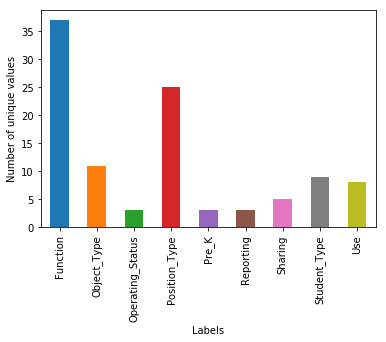

In [8]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique, axis=0)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

In [9]:
num_unique_labels

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64

In [10]:
np.sum(num_unique_labels)

104

##### Let's save the unique labels for each output (target)

In [11]:
# build a dictionary
cols_dict = {col : df[col].unique().tolist() for col in df[LABELS].columns}

In [12]:
# look at one target
cols_dict['Use']

['Instruction',
 'NO_LABEL',
 'O&M',
 'Pupil Services & Enrichment',
 'ISPD',
 'Leadership',
 'Business Services',
 'Untracked Budget Set-Aside']

#### Setting up a train-test split  for modeling

The first step is to split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. The function multilabel_train_test_split (in this directory) will make sure at least *min_count* examples of each label appear in each split.

We start with a simple model that uses just the numeric columns of the when calling multilabel_train_test_split. 

Also, we one-hot encode the labels as advised in the tutorial.  This creates 104 columns of binary label columns.

In [13]:
from python.multilabel import multilabel_train_test_split

In [14]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [15]:
# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 8.6 MB
None


In [16]:
df[NUMERIC_COLUMNS].shape

(400277, 2)

#### Start with a simple model

The first model ignores everything but the two numeric columns just to get started and check for correct format (104 columns of predictions).  Create a multi-label classifier clf by placing LogisticRegression() inside OneVsRestClassifier().

This simple model has the advantage of providing a working model in that it consumes the input properly and produces output in the correct format (in this case, we are looking for probability estimates for each target/label combination).

With this model as scaffolding we can proceed to models that are more detailed and produce better results.

In [17]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

start = timer()
# Fit the classifier to the training data
clf.fit(X_train, y_train)
end = timer()
print('fit time: {:02f} seconds'.format(end - start))

fit time: 124.24018694324036 seconds


In [18]:
# Predict label outputs for the accuracy score.
from sklearn.metrics import accuracy_score

yhat_train = clf.predict(X_train)
yhat_test = clf.predict(X_test)

#### Not accurate but  correct output format.
The sklearn.metrics.accuracy function isn't strictly applicable because the predictions this model produces are somewhat different from what it expects.  To summarize: the model is better than this - see first_models_metrics.ipynb for details.

In [19]:
print('train accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))
print('test accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))

train accuracy: 0.00
test accuracy: 0.00


#### Use  model to predict values on holdout data

The competition provides an additional test set, for which we never see the correct labels. This is called the holdout set.

The goal is to predict the probability of each label. Here we predict the probabilites.

In [20]:
# Load the holdout data
holdout = pd.read_csv('data/TestData.csv', index_col=0)

start = timer()
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))
end = timer()

print('predict time: {} seconds'.format(end - start))

predict time: 0.1385751678190843 seconds


C:\Users\saus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
# check shape
predictions.shape

(50064, 104)

In [22]:
# look at the upper left corner to get a sense
predictions[:5, :5]

array([[0.03582155, 0.00656506, 0.00081719, 0.02396992, 0.0090299 ],
       [0.03582447, 0.00656514, 0.00081721, 0.0239705 , 0.00902993],
       [0.11990636, 0.01798188, 0.00133432, 0.02284447, 0.01621812],
       [0.11963236, 0.01797478, 0.00133369, 0.02282747, 0.01621628],
       [0.12028213, 0.01799161, 0.00133517, 0.02286775, 0.01622063]])

#### Build a dataframe for the predictions and write to file for submission.

In [23]:
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=predictions)

prediction_df.to_csv('predictions.csv')

#### Submitted this prediction file. Scored 1.3314.

### Add text processing to the model

#### Combining text columns for tokenization

The tutorial recommends combining all the text columns into a single string.

In [24]:
# define function to combine all the text features into one string
def combine_text_columns(df, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text columns in each row of df to single string """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis=1)  
    # Replace nans with blanks
    text_data.fillna('', inplace=True)    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [25]:
# test it
combine_text_columns(df.sample(n=10))

145726    SUPPLIES  PROGRAM IMPROVEMENT INSTR      IMPRO...
84064     Classroom Supplies  Special Instruction    Gen...
74430     ADDITIONAL/EXTRA DUTY PAY/STIP GRANTS MANAGEME...
175690    Other Professional and Technical Services  Sup...
25818     Salaries And Wages For Substitute Professional...
106564    ADDITIONAL/EXTRA DUTY PAY/STIP  ARRA - STIMULU...
114852    SUPPLIES  CATEGORY III EXP ONLY SPECIAL ED    ...
369630    ADDITIONAL/EXTRA DUTY PAY/STIP TIF GRANT FEDER...
152383    EMPLOYER PD MED CONTRIBUTION  GENERAL FUND Tea...
318512    Regular * TEACHER Regular Instruction TCHR, K-...
dtype: object

#### A quick look at CountVectorizer

Now we use combine_text_columns to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

In the next cell, we compare the effect of tokenizing using any non-whitespace characters as a token and using only alphanumeric characters as a token.

In [26]:
# Import the CountVectorizer
from  sklearn.feature_extraction.text import CountVectorizer
# Create the basic token pattern; separates based on whitespace
TOKENS_BASIC = '\\S+(?=\\s+)'
# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)
# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)
# Create the text vector
text_vector = combine_text_columns(df)
# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)
# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))
# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)
# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


In [27]:
print(vec_basic.get_feature_names()[:16])

['"(year', '"building', '"guidance,', '"human', '"maintenance,', '"multilingual', '"performing', '"software,', '"technology', '"title', '%', '&', '&materials', '&program', '&wildlife', '(']


In [28]:
print(vec_alphanumeric.get_feature_names()[:16])

['00a', '12', '1st', '2nd', '3rd', '4th', '5', '56', '5th', '6', '60', '60hrs', '6th', '70', '70h', '70hr']


#### Add pipeline

The tutorial introduces a pipeline to consolidate preprocessing and modeling in a single classifier/estimator and to facilitate experimentation with both preprocessing and different models.

The function multilabel_train_test_split ensures that all splits have at least a minimum representation of all possible labels.

In [29]:
# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

#### Build the pipeline

In [30]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer())]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
    ])

start = timer()
# Fit to the training data
pl.fit(X_train, y_train)
end = timer()
print('fit time: {:.2f} seconds'.format(end - start))

fit time: 587.03 seconds


In [31]:
# Get model output (values, not probabilities)
yhat_train = pl.predict(X_train)
yhat_test = pl.predict(X_test)

In [32]:
# Print the accuracy scores
print('train accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))
print('test accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))

train accuracy: 0.35
test accuracy: 0.35


#### Again, this accuracy score is well below the model's actual quality due to how the OneVsRest(Log) does prediction.

#### predict probabilities and write submission

In [33]:
start = timer()
# Generate predictions: this time probabilities
predictions = pl.predict_proba(holdout)
end = timer()
print('predict time: {} seconds'.format(end - start))

predict time: 2.548470860289399 seconds


In [34]:
start = timer()
# Generate predictions: predictions
predictions = pl.predict_proba(holdout)
end = timer()
print('predict time: {} seconds'.format(end - start))

prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=predictions)

prediction_df.to_csv('sub2.csv')

predict time: 2.820025169776045 seconds


### Submitted and scored with log-loss of 0.7456.

***

***

#### Try a different class of model

This model illustrates the flexibilty of the pipeline.  Random Forest Classifier can be swapped in for the OneVsRest(LogisticReg..) by redefining the 'clf' step of the pipeline.

#####  Note: Unlike the model above,  the  RandomForestClassifier's produces probability predictions in a different format (list of 104 2-d arrays with a probability for both 1 and 0).  This needs to be reshaped for submission.

In [64]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl_rf = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_jobs=-1))
    ])
start = timer()
# Fit to the training data
pl_rf.fit(X_train, y_train)
end = timer()
print('fit time: {} seconds'.format(end - start))

fit time: 157.2157562516295 seconds


In [65]:
# Compute and print accuracy
# Print the accuracy scores
yhat_train = pl_rf.predict(X_train)
yhat_test = pl_rf.predict(X_test)

In [66]:
print('train accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))
print('test accuracy: {:.2f}'.format(accuracy_score(yhat_test, y_test)))

train accuracy: 0.99
test accuracy: 0.90


#### Predict probabilities

In [38]:
start = timer()
# Generate predictions: predictions
rf_predictions = pl_rf.predict_proba(holdout)
end = timer()
print('predict time: {:.2f} seconds'.format(end - start))

predict time: 6.35725108526583 seconds


#### Probability predictions are a list of arrays.

In [39]:
type(rf_predictions)

list

In [40]:
rf_predictions[0]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [41]:
rf_predictions[0].shape

(50064, 2)

In [42]:
len(rf_predictions)

104

##### We have 104 elements in predictions, each of which is an array (50064, 2).  

RFC probabilities are a list with num_target_cols elements, each of which is array (num_samples, num_labels).  RFC (along with many other classifiers) is happy to predict any number of mutually exclusive labels in a target column.  In this case our 'labels' are 1 and 0, so the constituent arrays are in the shape (50064, 2).  The first array position is the probability of 0 output; the second position is probabilty for 1 output.

In [43]:
# grab the probabilities for 1 from the probas; transpose goes from rows to columns
pred_rf = pd.DataFrame(data=[x[:, 1] for x in rf_predictions]).T

In [44]:
# check the shape
pred_rf.shape

(50064, 104)

In [45]:
# get the right column names and index
pred_rf.columns = pd.get_dummies(df[LABELS], prefix_sep='__').columns
pred_rf.index = holdout.index
# take a look, to see if we have the right characteristics
pred_rf.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,...,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,...,0.1,0.0,0.5,0.5,0.0,0.1,0.1,0.8,0.1,0.1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.1,0.7,0.0,0.0,0.5,0.2,0.1,0.2,0.0,0.0
28872,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.2,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,...,0.0,0.0,0.5,0.5,0.0,0.0,0.3,0.7,0.1,0.0,0.7,0.2,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.7,0.1,0.1,0.1,0.1,0.1,0.3,0.2,0.0
186915,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.3,0.0,0.0,0.0,...,0.3,0.0,0.8,0.2,0.0,0.0,0.1,0.9,0.1,0.0,0.9,0.0,0.0,0.0,0.0,0.1,0.0,0.3,0.0,0.0,0.0,0.6,0.0,0.2,0.4,0.2,0.1,0.0,0.1,0.0
412396,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,...,0.4,0.0,0.9,0.1,0.0,0.0,0.2,0.8,0.1,0.1,0.8,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,0.0,0.0,0.5,0.0,0.2,0.4,0.1,0.2,0.0,0.1,0.0
427740,0.2,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,...,0.1,0.0,0.6,0.3,0.1,0.1,0.3,0.6,0.1,0.1,0.6,0.1,0.1,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.1,0.6,0.1,0.0,0.3,0.1,0.2,0.1,0.2,0.0


In [46]:
# compare to previous prediction
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,...,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.035044,0.009033,0.000020,0.005156,0.004115,0.000051,0.023341,0.012113,0.017187,0.000016,0.002960,0.004691,0.000383,0.000736,0.106760,0.000100,0.000050,0.005736,0.119529,0.006688,0.025591,0.003441,0.005528,0.019680,0.000008,0.000735,0.024214,0.003384,0.001597,0.011827,...,0.066468,0.001552,0.685863,0.268437,0.006203,0.102979,0.131416,0.810076,0.024852,0.103729,0.841351,0.034106,0.086982,0.000772,0.000623,0.005840,0.000681,0.255563,0.011720,0.000045,0.076170,0.517811,0.004018,0.034925,0.548877,0.028157,0.208611,0.048271,0.076109,0.003594
28872,0.043341,0.004671,0.000158,0.007053,0.004726,0.000033,0.346247,0.032432,0.066243,0.000027,0.009442,0.006800,0.000579,0.001067,0.062761,0.000037,0.000237,0.004635,0.012955,0.000677,0.000803,0.007210,0.015402,0.023446,0.000046,0.005893,0.069195,0.003190,0.002421,0.012070,...,0.165565,0.003492,0.764101,0.253937,0.004298,0.011162,0.393182,0.693085,0.071155,0.023945,0.677781,0.085284,0.183946,0.000476,0.001791,0.014778,0.001482,0.047052,0.013795,0.000074,0.055897,0.833639,0.047163,0.030864,0.304865,0.123692,0.058561,0.112773,0.426434,0.000275
186915,0.068035,0.023687,0.000013,0.003775,0.002454,0.000007,0.014611,0.004399,0.014048,0.000007,0.002093,0.001688,0.000408,0.000297,0.076740,0.000010,0.000044,0.002104,0.027777,0.000098,0.005738,0.002662,0.014151,0.008969,0.000004,0.000181,0.033915,0.001949,0.000319,0.008079,...,0.116599,0.000777,0.882500,0.049357,0.006004,0.018001,0.110613,0.822952,0.015549,0.025805,0.774871,0.027887,0.058084,0.000391,0.000875,0.023295,0.000513,0.188035,0.008833,0.000131,0.095172,0.384363,0.006559,0.016105,0.712228,0.035126,0.085500,0.022647,0.071729,0.000102
412396,0.067884,0.023532,0.000013,0.003762,0.002443,0.000007,0.014568,0.004390,0.014010,0.000007,0.002088,0.001686,0.000406,0.000296,0.076481,0.000010,0.000044,0.002098,0.027708,0.000098,0.005717,0.002656,0.014106,0.008953,0.000004,0.000180,0.033843,0.001943,0.000319,0.008061,...,0.118218,0.000775,0.882676,0.049284,0.005990,0.017923,0.110500,0.823951,0.015511,0.025785,0.777487,0.027844,0.058031,0.000391,0.000873,0.023209,0.000512,0.190932,0.008823,0.000131,0.094927,0.382252,0.006515,0.016055,0.713104,0.035043,0.085294,0.022625,0.071502,0.000102
427740,0.052017,0.211306,0.000247,0.002943,0.006818,0.000011,0.016244,0.002897,0.044838,0.000008,0.006023,0.004567,0.000197,0.000621,0.046854,0.000016,0.000206,0.006088,0.018502,0.000166,0.000454,0.00234

In [47]:
# check index and column names are the same
all(prediction_df.index == pred_rf.index), all(prediction_df.columns == pred_rf.columns)

(True, True)

In [62]:
 pred_rf.to_csv('sub_rf_defaults.csv')

#### Submitted and scored  holdout set predictions at  1.6941.   Much worse score in competition despite the very good test accuracy.

### Add features to the pipeline

1. Add bigrams to CountVectorizer and tokenize on alphanumeric (previously was used with default settings)
2. Dimension reduction with SelectKBest using chi-squared (300 features).
3. Scale all features to range \[-1, 1\] with MaxAbsScaler
4. Go back to OneVsAll(LogisticRegression)

In [49]:
# Select 300 best features
chi_k = 300

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl_03 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    # soup up vectorizer a bit
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  # adding bigrams
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

##### Tutorial doesn't fit or predict with this model in the tutorial.  It seems natural to do that.

In [50]:
start = timer()
# Fit to the training data
pl_03.fit(X_train, y_train)
end = timer()
print('fit time: {:.2f} seconds'.format(end - start))

fit time: 586.9454308111488 seconds


In [51]:
# Compute and print accuracy
# Print the accuracy scores
yhat_train = pl_03.predict(X_train)
yhat_test = pl_03.predict(X_test)

In [52]:
print('train accuracy: {:.4f}'.format(accuracy_score(yhat_train, y_train)))
print('test accuracy: {:.4f}'.format(accuracy_score(yhat_train, y_train)))

train accuracy: 0.55
test accuracy: 0.55


In [61]:
start = timer()
# Generate predictions: predictions
predictions_03 = pl_03.predict_proba(holdout)
end = timer()
print('predict time: {:.2} seconds'.format(end - start))

prediction_df_03 = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=predictions_03)

prediction_df_03.to_csv('sub3.csv')

predict time: 3.6259336847979284 seconds


#### Submitted model with bigrams, dimension reduction and scaling - score is 0.8174.  Not as good as first model, but  close.

It may be that tossing all those features (there are 29k of them) is overdoing it.  It's be that they've done it to minimize processing time.

### Add feature interactions 

The tutorial provides a utility transformer called SparseInteractions. This adds features to the model based on the combination of each feature pair (i.e. cross-product of wordvec features).

The tutorial shows two models (called pl04 and pl05).  I went directly to pl05. Neither one of these model is fitted in the tutorial.

In [54]:
from python.sparse_interactions import SparseInteractions

# Instantiate pipeline: pl
pl04 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        # Now add the interaction features to the selected feature set
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

### Use hashing vectorizer instead of CountVectorizer

For the final model they swap vectorizer claiming computational advantages.

In [55]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl05 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
    ])

### This is the  final model in the tutorial.  Fit and see how it does.

In [56]:
start = timer()
# Fit to the training data
pl05.fit(X_train, y_train)
end = timer()
print('fit time: {:.2} seconds'.format(end - start))

# Compute and print accuracy
accuracy = pl05.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


fit time: 3606.163022079796 seconds


C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)



Accuracy on budget dataset:  0.7799762663169071


##### That took ~ 1 hour.  Accuracy is better.  Now submit.

In [58]:
start = timer()
# Generate predictions: predictions
predictions = pl05.predict_proba(holdout)
end = timer()
print('predict time: {:.2} seconds'.format(end - start))

prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=predictions)

prediction_df.to_csv('subm4.csv')

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


predict time: 39.612105117842475 seconds


In [59]:
# Compute and print accuracy
# Print the accuracy scores
yhat_train = pl05.predict(X_train)
yhat_test = pl05.predict(X_test)

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [60]:
print('train accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))
print('test accuracy: {:.2f}'.format(accuracy_score(yhat_train, y_train)))

train accuracy: 0.79
test accuracy: 0.79


###  Final model as presented in tutorial scores 0.8893 on the holdout.  This is considerably worse than simpler earlier models.  

In the next notebooks we'll explore metrics in detail and see what can be learned about each of these models.